In [1]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 30.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0


## Local Inference on GPU
Model page: https://huggingface.co/google/t5-efficient-tiny

⚠️ If the generated code snippets do not work, please open an issue on either the [model repo](https://huggingface.co/google/t5-efficient-tiny)
			and/or on [huggingface.js](https://github.com/huggingface/huggingface.js/blob/main/packages/tasks/src/model-libraries-snippets.ts) 🙏

In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/t5-efficient-tiny")
model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-efficient-tiny")

model.gradient_checkpointing_enable()
model.config.use_cache = False

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset

ds = load_dataset("abisee/cnn_dailymail", "3.0.0")

README.md: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/62.3M [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [5]:
prefix = "summarize: "
max_source_len = 384
max_target_len = 128

def preprocess(batch):
    inputs = [prefix + x for x in batch["article"]]
    model_inputs = tokenizer(inputs, max_length=max_source_len, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch["highlights"], max_length=max_target_len, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

cols = ds["train"].column_names
tokenized = ds.map(preprocess, batched=True, remove_columns=cols)

train_ds = tokenized["train"].select(range(5000))
eval_ds  = tokenized["validation"].select(range(50))


Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [6]:
!pip install -q evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=e1f3e21d323e0458fb616c9e8023cdb978a7c7a37c67b2d54d651845147ac4ff
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [7]:
import numpy as np, evaluate
rouge = evaluate.load("rouge")

def _safe_ids(arr, pad_id, vocab_size=None):
    arr = np.array(arr)

    if arr.ndim == 3:
        arr = arr[:, 0, :]

    if arr.dtype.kind != "i":
        arr = arr.astype("int64", copy=False)

    arr[arr < 0] = pad_id
    if vocab_size:
        arr = np.where(arr >= vocab_size, pad_id, arr)
    return arr

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    if isinstance(preds, tuple):
        preds = preds[0]
    pad_id = tokenizer.pad_token_id or 0
    vocab_size = getattr(tokenizer, "vocab_size", None)

    preds  = _safe_ids(preds,  pad_id, vocab_size)
    labels = _safe_ids(np.where(labels != -100, labels, pad_id), pad_id, vocab_size)


    decoded_preds  = tokenizer.batch_decode(preds.tolist(),  skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels.tolist(), skip_special_tokens=True)

    decoded_preds  = [p.strip() for p in decoded_preds]
    decoded_labels = [l.strip() for l in decoded_labels]
    scores = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    return {k: round(v * 100, 4) for k, v in scores.items()}


In [10]:
from transformers import DataCollatorForSeq2Seq
collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [9]:
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
)

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5efftiny-cnndm-full",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=True,
    report_to="none",
    fp16=False,
    predict_with_generate=True,
    generation_max_length=128,
    generation_num_beams=4,
)

In [12]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/tmp/ipython-input-341489654.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
100,6.777100
200,5.045900
300,4.821500
400,4.726200
500,4.540500
600,4.521800
700,4.494400
800,4.391500
900,4.373100
1000,4.329000


TrainOutput(global_step=2500, training_loss=4.440614526367187, metrics={'train_runtime': 177.0926, 'train_samples_per_second': 56.468, 'train_steps_per_second': 14.117, 'total_flos': 169244098560000.0, 'train_loss': 4.440614526367187, 'epoch': 2.0})

In [13]:
trainer.evaluate()

{'eval_loss': 3.1398255825042725,
 'eval_rouge1': 18.4403,
 'eval_rouge2': 6.1482,
 'eval_rougeL': 15.2065,
 'eval_rougeLsum': 15.0034,
 'eval_runtime': 14.5008,
 'eval_samples_per_second': 3.448,
 'eval_steps_per_second': 0.897,
 'epoch': 2.0}

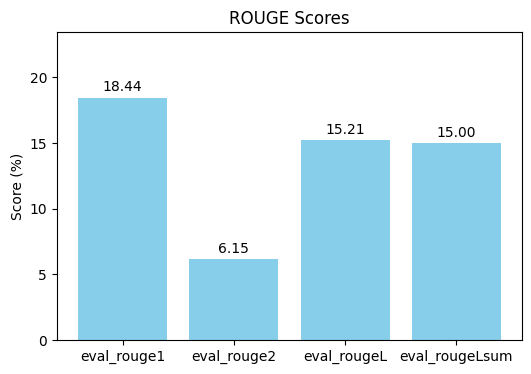

In [14]:
import matplotlib.pyplot as plt

metrics = {
    'eval_loss': 3.1398255825042725,
    'eval_rouge1': 18.4403,
    'eval_rouge2': 6.1482,
    'eval_rougeL': 15.2065,
    'eval_rougeLsum': 15.0034,
}

rouge_scores = {k: v for k, v in metrics.items() if 'rouge' in k}

plt.figure(figsize=(6, 4))
plt.bar(rouge_scores.keys(), rouge_scores.values(), color='skyblue')
plt.ylabel("Score (%)")
plt.title("ROUGE Scores")
plt.ylim(0, max(rouge_scores.values()) + 5)

for i, (k, v) in enumerate(rouge_scores.items()):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center')

plt.show()
